# BIG DATA FOR MARKETING 
  Dataset : Clients from a Portuguese Homebanking
  Dimention : 50.000 clients  
  Objective : Client segmentation

### Cluster Version Used: 6.4


## Indice     
   
A. **Import of Package e Dataset**  
B. **Data Understanding**  
C **Data Preparation**  
D. **Exploratory Data Analysis + Data Modification**      
E. **Feature Creation**    
F. **Modeling**

## A. Import of Package e Dataset

In [0]:
# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
#import missingno as msno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

# Machine Learning
import sklearn
import missingpy

import os
import requests
import sklearn as sc
import statsmodels.api as sm
from scipy.stats import kstest, zscore
import pylab as py
from scipy.stats import boxcox


spark = SparkSession.builder.getOrCreate()

In [0]:
#Import of CSV

# 1. Import Table
df = sqlContext.sql("SELECT * FROM clientes_bd")

# 2. Conversion to Pandas
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
clientes_bd = df.select("*").toPandas()

# Lambda to remove whitespaces from the dataset
clients_raw = clientes_bd.applymap(lambda x: x.strip() if isinstance(x, str) else x)

## B. Data Understanding

Initial data collection and familiarization; Identify data quality issues; Initial remarks

#### Features



**N_CLIENTE :** Client number  
**IDADE_CLIENTE :** Client age  
**C_PAIS_ISOA_RESI :** Client's country of residence   
**LOCALIDADE_MORD_RESI :** Location of the client's home address  
**LOCALIDADE_MORD_FSCL :** Location of the client's tax residence address  
**I_GNRO_CLI :** Client gender indicator (M/F)  
**GRAN_CLI_PRT :** Client segmentation  
**ESTADO_CIVIL :** Client's marital status  
**C_PAIS_ISOA_MORD_PRIN :** Client’s main address country   
**LOCALIDADE_MORD_PRIN :** Client’s main address location  
**Q_1TITULAR :** Number of active interventions in which the client is the first holder  
**Q_OUTRAS_TITULAR :** Number of active interventions in which the client is holder but not the first  
**Q_AUTORIZADO :** Number of active interventions in which the client is authorized  
**Q_FIADOR :** Number of active interventions in which the client is guarantor  
**Q_CARTOES :**  Number of active interventions related to cards  
**Q_PROFISSAO :**  Proof of profession indicator (1/0)  
**I_CDO_ATIV :** If there is an active Caixa Directa online contract associated with the client then S, if not N  
**Z_ADESAO_CDO :** Z_INIC_REL related with the active CaixaDirecta online contract  
**Q_CTA_CAIXA :** Number of active Conta Caixa contracts associated with the client  
**PFI_RIS_BRQM_CAP :** Client money laundering risk profile  
**C_PROF_CLI :** Client profession code  
**D_PROF_CLI :** Client profession  
**C_SIT_PROF :** Professional status code  
**D_SIT_PROF_CLI :** Professional status  
**C_TIPO_DPDC_TRBX :** Professional dependency type code  
**D_TIPO_DPDC_TRBX :** Professional dependency   
**D_HRIO_TEL1 :** Contact time with the client (indifferent, weekdays,…)    
**D_HRIO_TEL2 :** Contact time with the client (indifferent, weekdays,…)  
**D_HRIO_TEL3 :** Contact time with the client (indifferent, weekdays,…)  
**D_HRIO_TEL4 :** Contact time with the client (indifferent, weekdays,…)  
**D_HRIO_TM1 :** Contact time with the client (indifferent, weekdays,…)    
**D_HRIO_TM2 :** Contact time with the client (indifferent, weekdays,…)  
**D_SEGM_CLI_PRIN :**  Main client segment  
**I_FALENCIA :** Client has bankruptcy lock registered in this table  
**I_UTR_DO_BDP :** Client blocked by UTR of Portugues Bank (blacklist) registered in this table  
**M_VOLUME_NEGOCIOS :** Volume of business  
**M_CARTEIRA_PASSIVAS :** Sum of passive portfolio balance amounts  
**M_CARTEIRA_ACTIVAS :** Sum of active portfolio amounts  
**M_SLDO_SEGURO :** Sum of insurance balance  
**M_SLDO_VM :** Sum of vm balance amounts  
**M_GARANTIAS_BANCARIAS :** Sum of bank guarantee amounts  
**M_CREDITO_IMOBILIARIO :**  Sum of real estate credit amounts  
**M_CREDITO_PESSOAL :** Sum of personal credit amounts  
**I_VENCIMENTO :** Salary Flag - CGD  
**M_VENCIMENTO_ULT6M :** Average of salary amounts in the last 6 months

In [0]:
clients_raw.shape

Out[4]: (50057, 45)

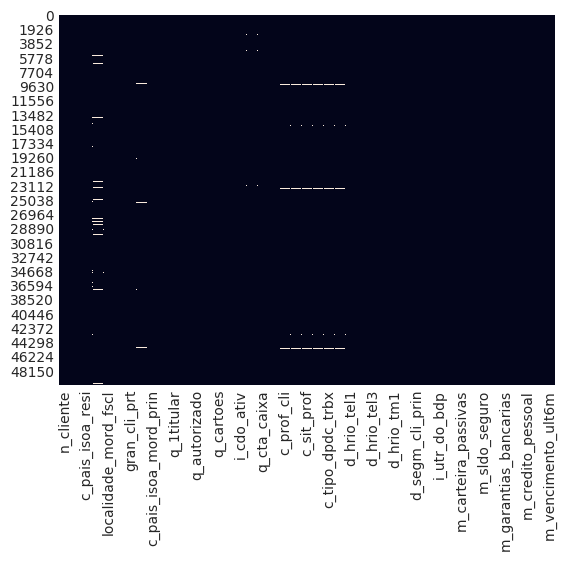

In [0]:
#Visualization of Missing Values 

display(sns.heatmap(clients_raw.isnull(), cbar=False))

## C. Data Preparation

  Feature selection; Data Cleaning ; Column Rename and export

#### 1. Data Cleaning

In [0]:
#Creating a Checkpoint Dataframe 
clients = clients_raw

In [0]:
# z_adesao_cdo

# replace default values with "2000-01-01"  ( business insight)
clients["z_adesao_cdo"] = [
    "2000-01-01" if x == "1754-08-28" else x
    for x in clients["z_adesao_cdo"].dt.date.astype(str)
]

# Null e Blanks Removal
clients["z_adesao_cdo"] = clients["z_adesao_cdo"].loc[clients["z_adesao_cdo"] != "NaT"]
clients.dropna(subset=["z_adesao_cdo"], inplace=True)

# estado_civil - Inputating Blank values with Desconhecido
clients["estado_civil"] = clients["estado_civil"].fillna("Desconhecido")

#d_prof_cli - Inputating Blank values with Desconhecido
clients['d_prof_cli'] = clients['d_prof_cli'].fillna("Desconhecido")

#d_sit_prof_cli - Inputating Blank values with Desconhecido
clients['d_sit_prof_cli'] = clients['d_sit_prof_cli'].fillna("Desconhecido")

#d_tipo_dpdc_trbx - Inputating Blank values with Desconhecido
clients['d_tipo_dpdc_trbx'] = clients['d_tipo_dpdc_trbx'].fillna("Desconhecido")



#### 2. Data Selection

In [0]:
clients = clients.drop(
    columns=[
        "localidade_mord_resi",
        "localidade_mord_fscl",
        "c_pais_isoa_mord_prin",
        "c_prof_cli",
        "c_sit_prof",
        "c_tipo_dpdc_trbx",
        "d_hrio_tel1",
        "d_hrio_tel2",
        "d_hrio_tel3",
        "d_hrio_tel4",
        "d_hrio_tm1",
        "d_hrio_tm2",
        "d_segm_cli_prin",
    ]
)


#### 3. Columns Rename and Export

In [0]:
clients.rename(
    columns={
        "n_cliente": "Cliente",
        "idade_cliente": "Idade",
        "c_pais_isoa_resi": "Pais",
        "i_gnro_cli": "Genero",
        "gran_cli_prt": "Tipo Caixa",
        "estado_civil": "Estado Civil",
        "localidade_mord_prin": "Localidade",
        "q_1titular": "Qt Titulares",
        "q_outras_titular": "Qt Outros Titulares",
        "q_autorizado": "Qt Autorizado",
        "q_fiador": "Qt Fiadores",
        "q_cartoes": "Qt Cartões",
        "q_profissao": "Qt Profissões",
        "i_cdo_ativ": "Homebanking",
        "z_adesao_cdo": "Data Adesão",
        "q_cta_caixa": "Conta Caixas Activas",
        "pfi_ris_brqm_cap": "Risco de Lavagem Dinheiro",
        "d_prof_cli": "Profissão",
        "d_sit_prof_cli": "Tipo de Profissão",
        "d_tipo_dpdc_trbx": "Dependencia Profissional",
        "i_falencia": "Falência",
        "i_utr_do_bdp": "Bloqueados UTR",
        "m_volume_negocios": "Volume Negocios",
        "m_carteira_passivas": "Carteira Passiva",
        "m_carteira_activas": "Carteira Activas",
        "m_sldo_seguro": "Saldo Seguros",
#       "m_sldo_vm": "Balanca VM ",
        "m_garantias_bancarias": "Garantia Bancaria",
        "m_credito_imobiliario": "Credito Imobiliario",
        "m_credito_pessoal": "Credito Pessoal",
        "i_vencimento": "Recebe Salario",
        "m_vencimento_ult6m": "Media de Salario a 6 meses",
    },
    inplace=True,
)



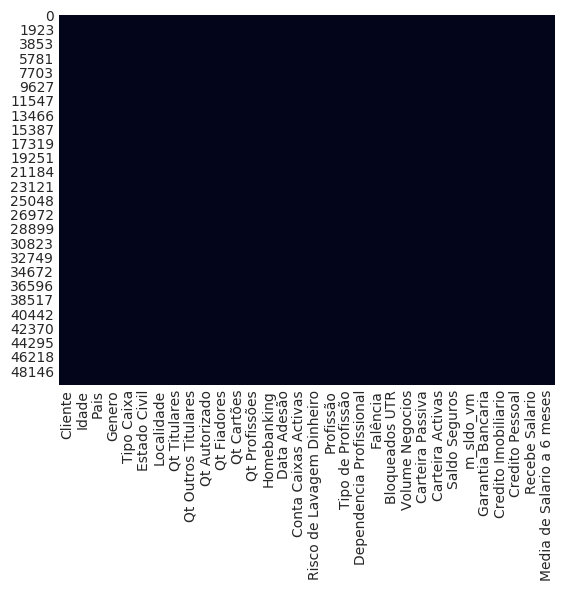

In [0]:
#Visualization of Missing Values after cleaning

display(sns.heatmap(clients.isnull(), cbar=False))

## D. Exploratory Data Analysis + Data Modification

EDA and Data Modification back to back

In [0]:
summary=clients.describe(include='all')
summary=summary.transpose()
summary.head(len(summary))


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Cliente,49741,49741,92ce03ce51104c5b9d4e86734ea3712a,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Idade,49741,NaN,NaN,NaN,41.7928,13.1705,18,31,41,50,97
Pais,49741,87,PT,46217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genero,49741,2,M,25530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tipo Caixa,49741,3,CAIXA MAIS,43288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Estado Civil,49741,12,SOLTEIRO,28175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Localidade,49739,8852,LISBOA,3746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Qt Titulares,49741,NaN,NaN,NaN,2.06612,1.25258,0,1,2,3,14
Qt Outros Titulares,49741,NaN,NaN,NaN,0.504433,1.16738,0,0,0,0,19
Qt Autorizado,49741,NaN,NaN,NaN,0.859392,1.7768,0,0,0,1,75


#### 1. Idade

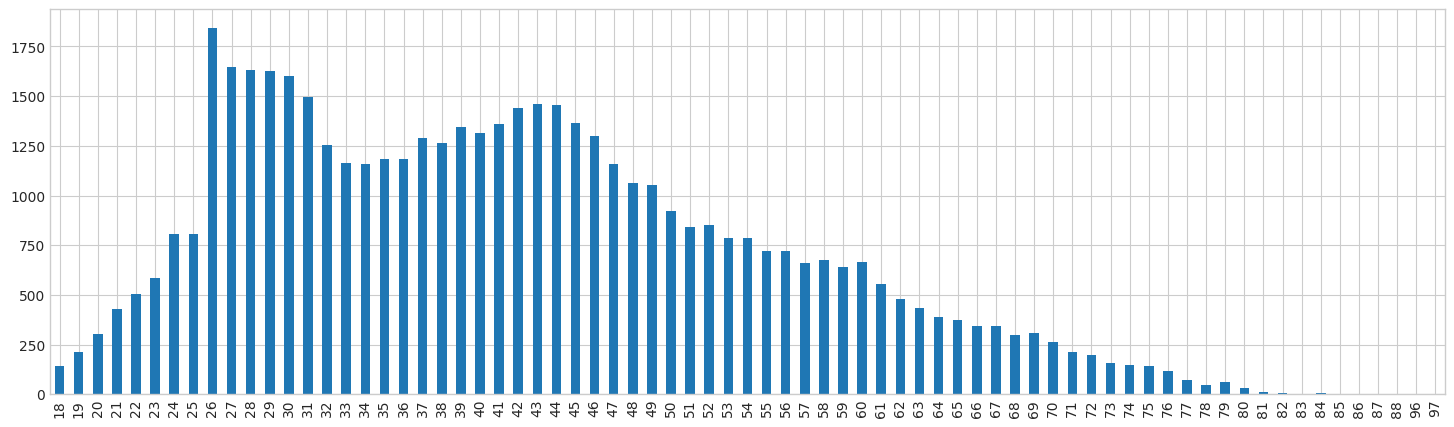

In [0]:
#Idade Variable

display(clients['Idade'].value_counts().sort_index().plot.bar(figsize=(18,5)))

In [0]:
#Upper limit in 80
clients['Idade'][clients['Idade'] >= 80] = 80

/local_disk0/tmp/1621675293122-0/PythonShell.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 from __future__ import print_function

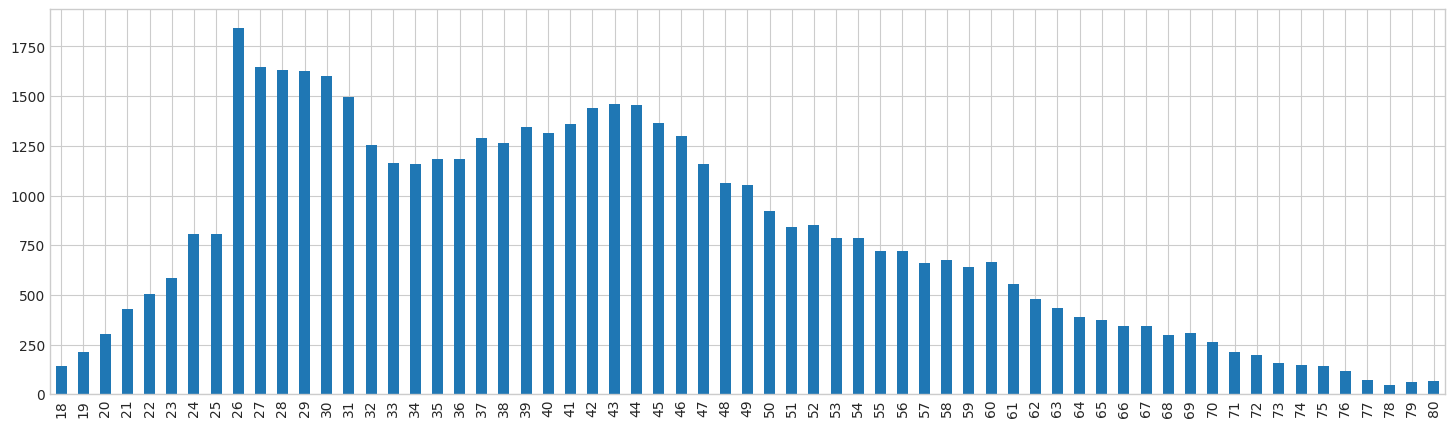

In [0]:
#Idade Variable

display(clients['Idade'].value_counts().sort_index().plot.bar(figsize=(18,5)))

#### 2. Pais

In [0]:
country_of_residence = clients['Pais']
print(country_of_residence.value_counts('Pais').sort_values(ascending = False))
#pd.set_option("display.max_rows", None, "display.max_columns", None)

# Dummy creation, 1 if Portuguese residence , 0 if not

clients['Pais'] = clients['Pais'].str.strip()
clients['Pais'] = [1 if x == 'PT' else 0 for x in clients['Pais']]
clients['Pais'].astype(int)

PT 0.929153
CH 0.015400
GB 0.011097
FR 0.009228
BR 0.005730
DE 0.003820
AO 0.003197
BE 0.003036
LU 0.001990
US 0.001689
MZ 0.001488
ES 0.001468
VE 0.001427
NL 0.001367
CA 0.000784
MO 0.000784
ZA 0.000764
PL 0.000764
CZ 0.000623
NO 0.000563
DK 0.000523
CN 0.000382
AU 0.000342
CV 0.000322
TL 0.000302
SE 0.000302
ST 0.000261
IE 0.000201
IT 0.000201
AE 0.000141
 ... 
MA 0.000040
IS 0.000040
TH 0.000040
IL 0.000040
DZ 0.000020
AD 0.000020
SN 0.000020
ID 0.000020
PH 0.000020
GH 0.000020
BW 0.000020
DO 0.000020
BS 0.000020
VN 0.000020
GA 0.000020
KR 0.000020
PR 0.000020
MR 0.000020
CD 0.000020
TN 0.000020
MW 0.000020
MT 0.000020
SK 0.000020
CO 0.000020
KE 0.000020
BD 0.000020
GR 0.000020
UY 0.000020
BL 0.000020
SZ 0.000020
Name: Pais, Length: 87, dtype: float64
Out[16]: 0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 0
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
 ..
50027 1
50028 1
50029 1
50030 1
50031 1
50032 1
50033 1
50034 1
50035 1
50036 1
50037 1
50038 1
50039 1
50040 1
50041 1
50042 1
50043 1
50044 1
50045 1
50046 0
50047 1
50048 1
50049 1
50050 1
50051 1
50052 1
50053 1
50054 1
50055 1
50056 0
Name: Pais, Length: 49741, dtype: int64

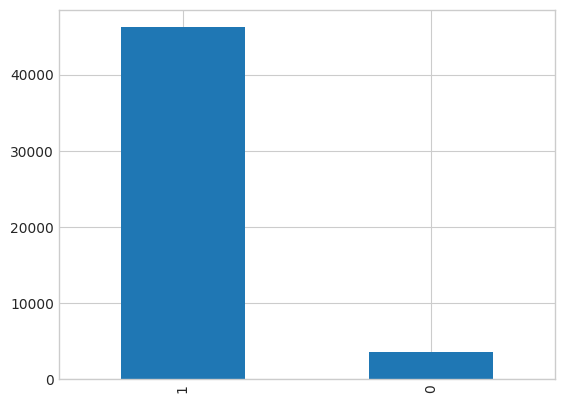

In [0]:
display(clients['Pais'].value_counts().plot.bar())

#### 3. Género

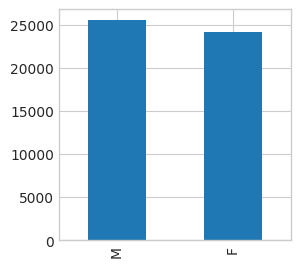

In [0]:
#Género dos clientes

display(clients['Genero'].value_counts().plot.bar(figsize=(3,3)))

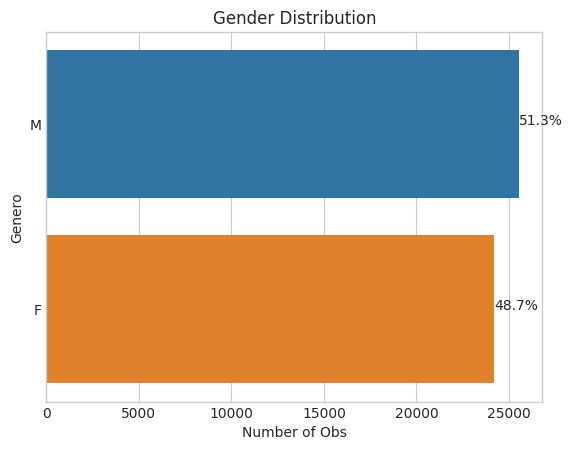

In [0]:
distribuiçao_genero = sns.countplot(y = 'Genero', data = clients)
plt.title('Gender Distribution')
plt.xlabel('Number of Obs')

total = len(clients['Genero'])
for p in distribuiçao_genero.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    distribuiçao_genero.annotate(percentage, (x, y))
display(plt.show())

# Equal distribution
# Dummy Creation

In [0]:
clients['Genero'] = [1 if x == "M" else 0 for x in clients['Genero']]

#### 4. Tipo Caixa

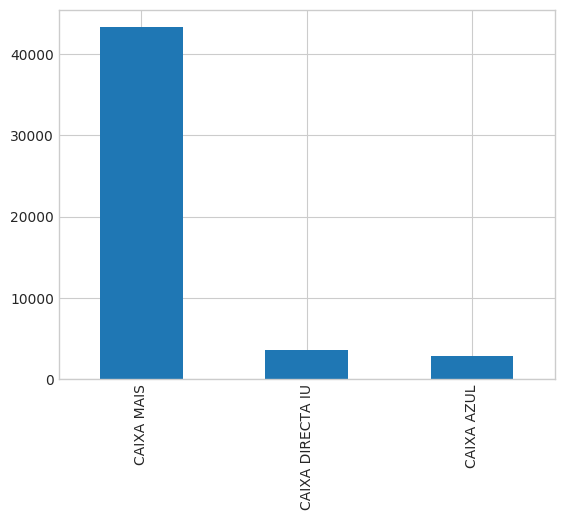

In [0]:
#Down the line we will perfome a dummy creation

display(clients['Tipo Caixa'].value_counts().plot.bar())

#### 5. Estado Civil

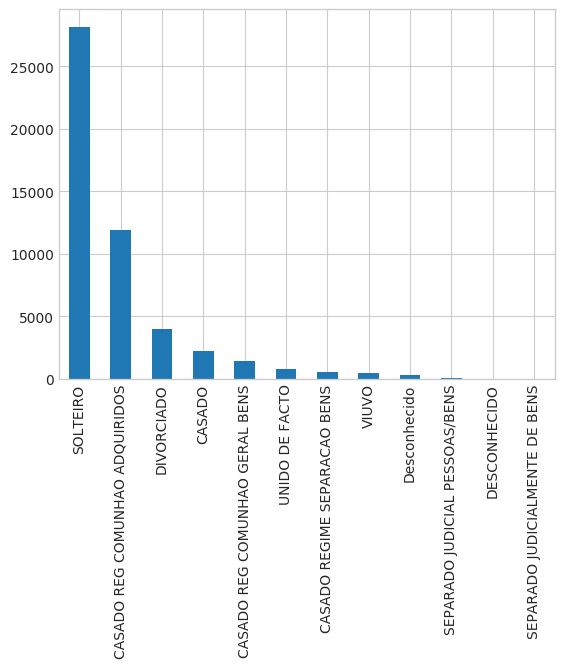

In [0]:
#Estado Civil
display(clients['Estado Civil'].value_counts().plot.bar())

In [0]:
# Binary variable where 1 is single, 0 married

clients['Estado Civil'] = [1 if x == 'SOLTEIRO' else 0 for x in clients['Estado Civil']]

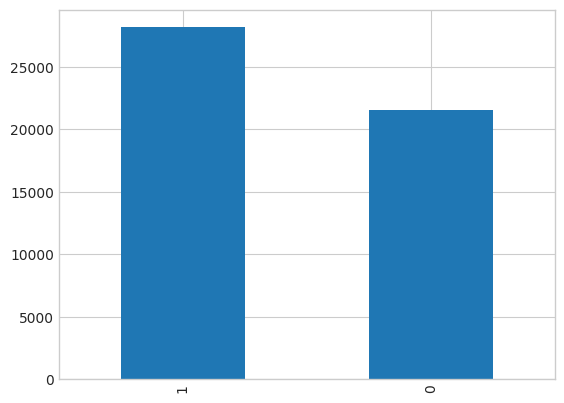

In [0]:
display(clients['Estado Civil'].value_counts().plot.bar())

#### 6.Variable Quantity

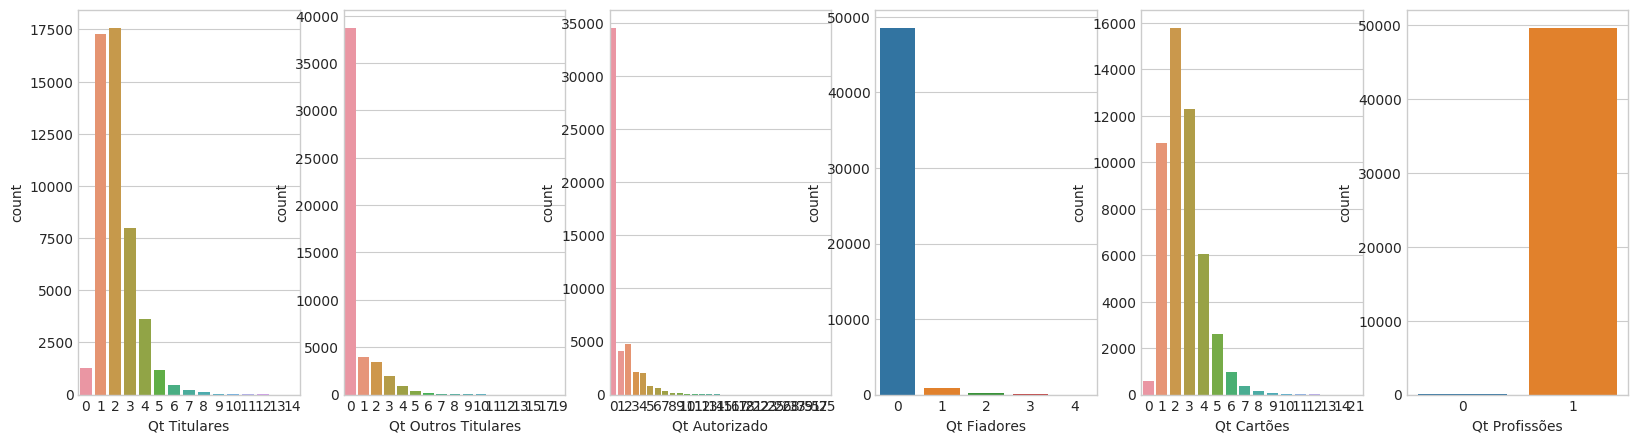

In [0]:
#Distribution by Education, Marital_Statuis and Income

fig, ax = plt.subplots(nrows = 1, ncols = 6, figsize = (20, 5))
sns.countplot(x="Qt Titulares",data= clients, ax=ax[0]) 
sns.countplot(x="Qt Outros Titulares",data= clients, ax=ax[1])
sns.countplot(x="Qt Autorizado",data= clients, ax=ax[2]) 
sns.countplot(x="Qt Fiadores",data= clients, ax=ax[3])
sns.countplot(x="Qt Cartões",data= clients, ax=ax[4])
sns.countplot(x="Qt Profissões",data= clients, ax=ax[5])
display(fig)

In [0]:
#Criar upper limits
clients['Qt Titulares'][clients['Qt Titulares'] >= 5] = 5
clients['Qt Outros Titulares'] = [0 if x == 0 else 1 for x in clients['Qt Outros Titulares']]
clients['Qt Autorizado'][clients['Qt Autorizado'] >= 7] = 7
clients['Qt Fiadores'] = [0 if x == 0 else 1 for x in clients['Qt Fiadores']]
clients['Qt Cartões'][clients['Qt Cartões'] >= 8] = 8

/local_disk0/tmp/1621675293122-0/PythonShell.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 from __future__ import print_function
/local_disk0/tmp/1621675293122-0/PythonShell.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import errno
/local_disk0/tmp/1621675293122-0/PythonShell.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import os

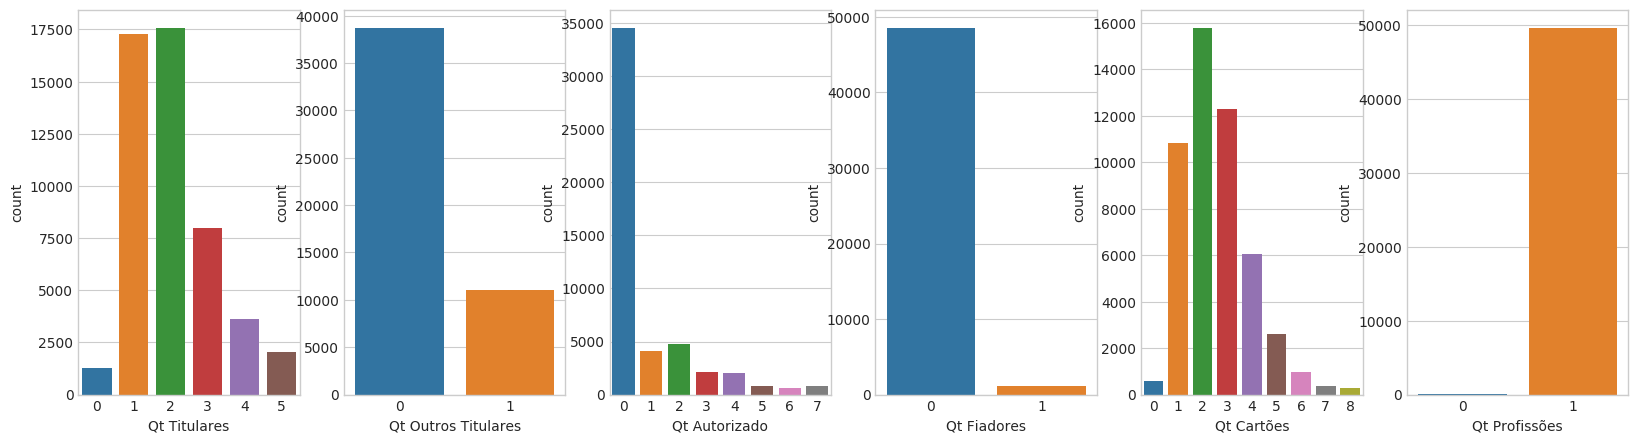

In [0]:
#Distribution by Education, Marital_Statuis and Income

fig, ax = plt.subplots(nrows = 1, ncols = 6, figsize = (20, 5))
sns.countplot(x="Qt Titulares",data= clients, ax=ax[0])
sns.countplot(x="Qt Outros Titulares",data= clients, ax=ax[1])
sns.countplot(x="Qt Autorizado",data= clients, ax=ax[2])
sns.countplot(x="Qt Fiadores",data= clients, ax=ax[3])
sns.countplot(x="Qt Cartões",data= clients, ax=ax[4])
sns.countplot(x="Qt Profissões",data= clients, ax=ax[5])
display(fig)

#### 7. Homebanking

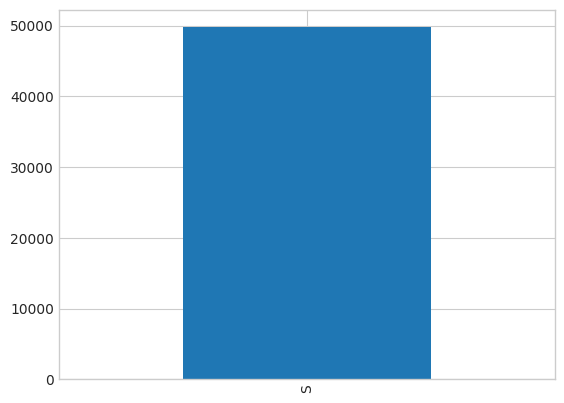

In [0]:
#Drop

display(clients['Homebanking'].value_counts().plot.bar())

#### 8. Data Adesão

In [0]:
#Way to many default values but will leave it as is

clients['Data Adesão'].value_counts().sort_index()

Out[29]: 2000-01-01 8051
2003-10-13 7
2003-10-14 6
2003-10-15 13
2003-10-16 20
2003-10-17 4
2003-10-20 11
2003-10-21 6
2003-10-22 5
2003-10-23 10
2003-10-24 16
2003-10-27 9
2003-10-28 6
2003-10-29 6
2003-10-30 6
2003-11-03 12
2003-11-04 9
2003-11-05 9
2003-11-06 15
2003-11-07 11
2003-11-10 8
2003-11-11 11
2003-11-12 7
2003-11-13 12
2003-11-14 12
2003-11-17 4
2003-11-18 7
2003-11-19 6
2003-11-20 12
2003-11-21 8
 ... 
2020-11-28 1
2020-11-30 2
2020-12-01 1
2020-12-02 2
2020-12-03 2
2020-12-04 3
2020-12-06 1
2020-12-07 3
2020-12-09 1
2020-12-10 1
2020-12-12 1
2020-12-14 2
2020-12-15 1
2020-12-16 1
2020-12-17 2
2020-12-30 2
2021-01-04 2
2021-01-05 1
2021-01-06 2
2021-01-07 1
2021-01-11 2
2021-01-12 2
2021-01-13 2
2021-01-14 2
2021-01-15 1
2021-01-17 1
2021-01-18 2
2021-01-19 1
2021-01-20 2
2021-01-21 1
Name: Data Adesão, Length: 4472, dtype: int64

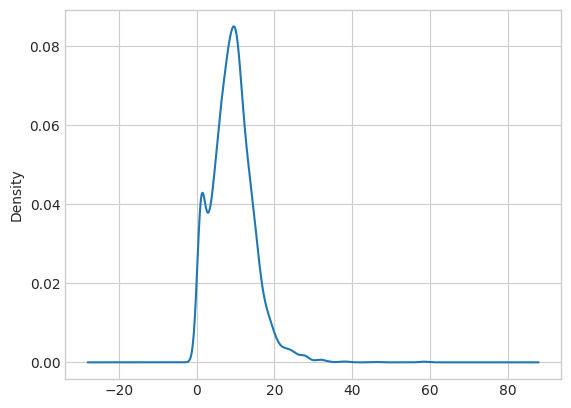

In [0]:
#Density of non default variables
clientes_after_2020 = clients['Data Adesão'][clients['Data Adesão'] != "2000-01-01" ]

display(clientes_after_2020.value_counts().sort_index().plot.kde())

#### 9. Conta Activa

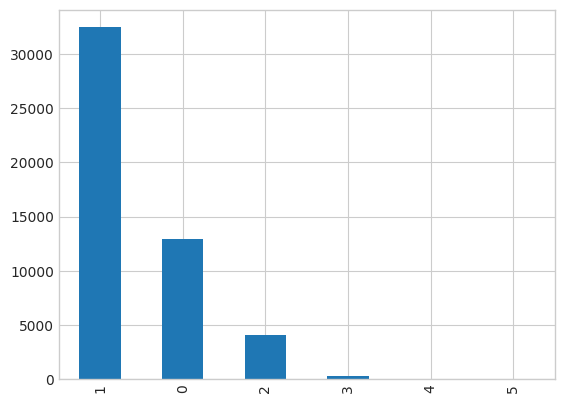

In [0]:
display(clients['Conta Caixas Activas'].value_counts().plot.bar())

In [0]:
#Upper Limites
clients['Conta Caixas Activas'][clients['Conta Caixas Activas'] >= 2] = 1

/local_disk0/tmp/1621675293122-0/PythonShell.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 from __future__ import print_function

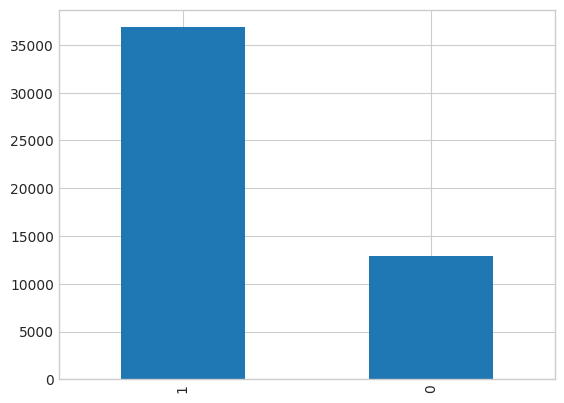

In [0]:
#Conta Caixas Activas

display(clients['Conta Caixas Activas'].value_counts().plot.bar())

#### 10. Risco de Lavagem Dinheiro

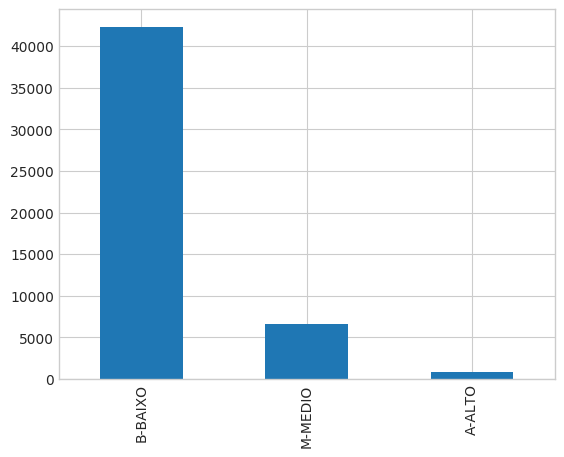

In [0]:
#Binary

display(clients["Risco de Lavagem Dinheiro"].value_counts().plot.bar())

In [0]:
print(clients['Risco de Lavagem Dinheiro'].value_counts()) # there is a huge asymmetry among labels of the variable. Lets assume a dummy with 1 for low risk and 0 for medium or high risk

clients['Risco de Lavagem Dinheiro'] = [1 if x == 'B-BAIXO' else 0 for x in clients['Risco de Lavagem Dinheiro']]

B-BAIXO 42325
M-MEDIO 6604
A-ALTO 812
Name: Risco de Lavagem Dinheiro, dtype: int64

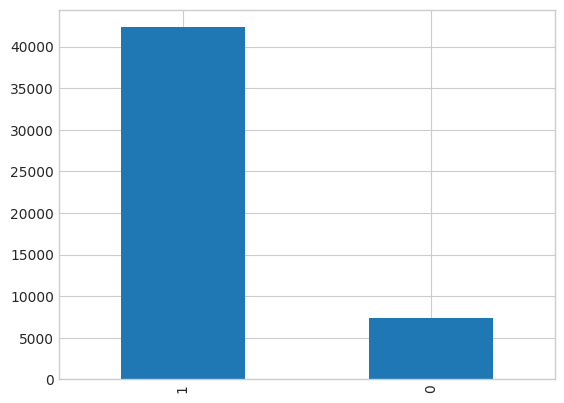

In [0]:

display(clients["Risco de Lavagem Dinheiro"].value_counts().plot.bar())

#### 11.Profession Variables

#### 11.1 Profissão

In [0]:
#There are 572 unique professions, we could define a threshhold to create a top 10 largest professions. we could manipulate these 10 bins with only engineer, only professors. we might lose information on our variables but will be able to understand them better

profissao = clients['Profissão']
print('Numero de profissões únicas existentes:', len(profissao.unique().tolist()), '\n\n') 
print(profissao.value_counts()[0:14])

Numero de profissões únicas existentes: 572 


ESTUDANTE 10260
PROF.ENS.BASICO(2º 3º)SECUND. 2991
FUNCIONARIO PUBLICO 2313
EMPREGADO ESCRITORIO GERAL 1975
OUTROS AGENTES POLICIA 1165
ENFERMEIRO CUIDADOS GERAIS 998
SEM PROFISSAO 899
ARQUITETO EDIFICIOS 803
PROF.ENSINO BASICO (1º CICLO) 699
OUT.TRAB.RELACION.VNDS N.E. 660
ESPEC.VNDS TEC.INF.COMUN.(TIC) 569
CONTAB.AUD.REV.OF.CTAS SIM. 550
ADVOGADO 533
TECNICO DE SECRETARIADO 521
Name: Profissão, dtype: int64

#### 11.2 Tipo de Profissão

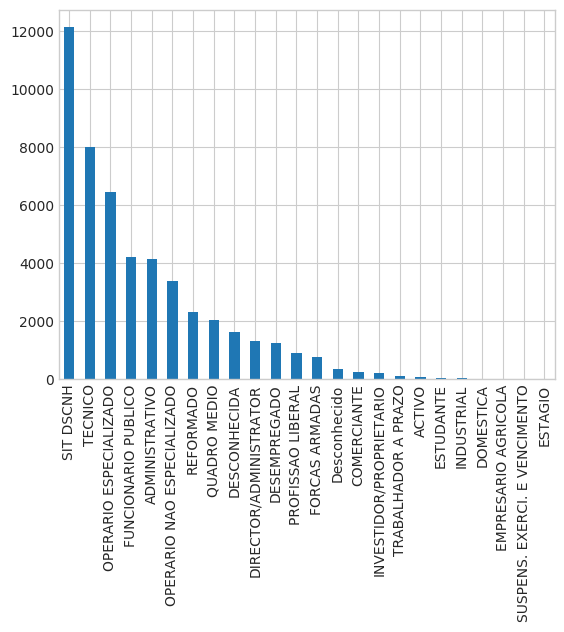

In [0]:
# Same treatment of above could be possible

display(clients["Tipo de Profissão"].value_counts().plot.bar())

#### 11.3 Dependencia Profissional

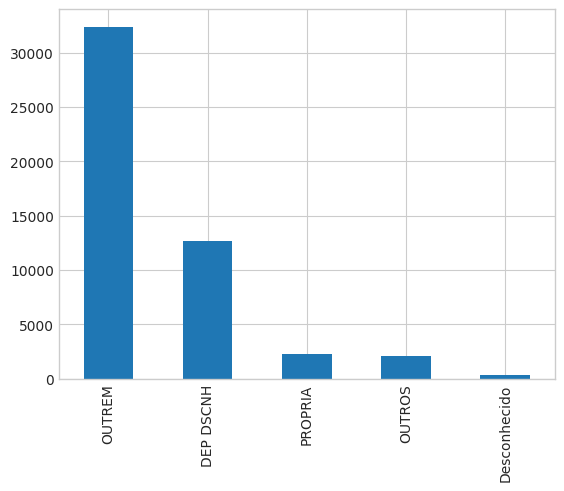

In [0]:
#Binary
display(clients["Dependencia Profissional"].value_counts().plot.bar())

In [0]:
clients['Dependencia Profissional'] = [1 if x == 'OUTREM' else 0 for x in clients['Dependencia Profissional']]

#### 12. Falência

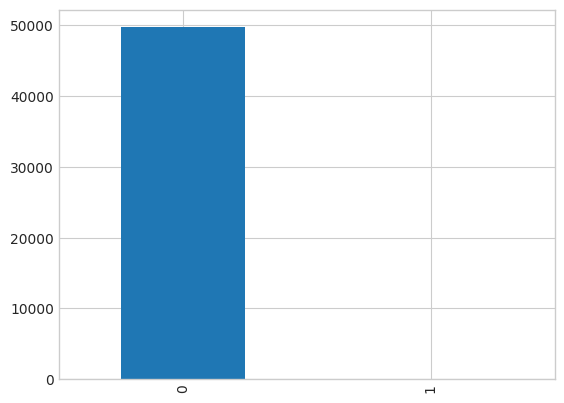

In [0]:
#Drop

display(clients["Falência"].value_counts().plot.bar())

#### 13. Bloqueados UTR

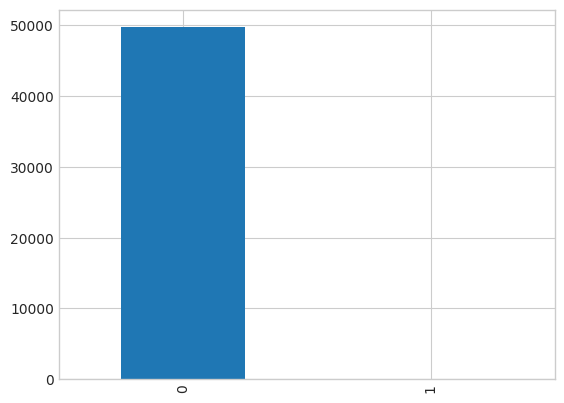

In [0]:
#Drop

display(clients["Bloqueados UTR"].value_counts().plot.bar())

#### 14. Monetary Variables

In [0]:
clients_QT = clients[[
  "Volume Negocios", 
  "Carteira Passiva", 
  "Carteira Activas",
  "Saldo Seguros",
  "m_sldo_vm",
  "Garantia Bancaria",
  "Credito Imobiliario",
  "Credito Pessoal",
  "Recebe Salario",
  "Media de Salario a 6 meses"
]]

summary=clients_QT.describe()
summary=summary.transpose()
summary.head(len(summary))

,count,mean,std,min,25%,50%,75%,max
Volume Negocios,49741.0,36142.661222,81346.154175,-4576.48,809.47,10306.87,47739.80,9724833.35
Carteira Passiva,49741.0,17453.975008,68590.119234,-8075.24,367.28,4102.39,18594.45,9724833.35
Carteira Activas,49741.0,18688.050416,43621.717530,0.00,0.00,0.00,4145.09,1080196.57
Saldo Seguros,49741.0,1589.006630,9010.791040,0.00,0.00,0.00,0.00,386440.71
m_sldo_vm,49741.0,2231.110337,35141.246265,0.00,0.00,0.00,0.00,5036143.09
Garantia Bancaria,49741.0,0.635798,64.155880,0.00,0.00,0.00,0.00,9000.00
Credito Imobiliario,49741.0,18349.270848,43529.026145,0.00,0.00,0.00,0.00,1080196.57
Credito Pessoal,49741.0,335.996471,2410.343807,0.00,0.00,0.00,0.00,201902.70
Media de Salario a 6 meses,49741.0,559.725667,797.762090,0.00,0.00,0.00,1085.21,22418.74


#### 14.0 Volume Negocios

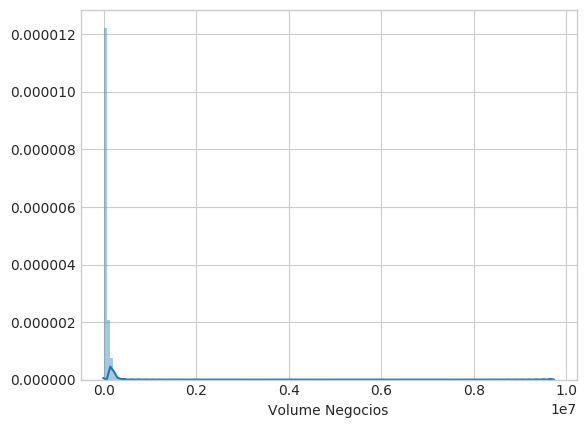

In [0]:
display(sns.distplot(clients["Volume Negocios"], kde=True, bins=150))

#### 14.1 Carteira Passiva

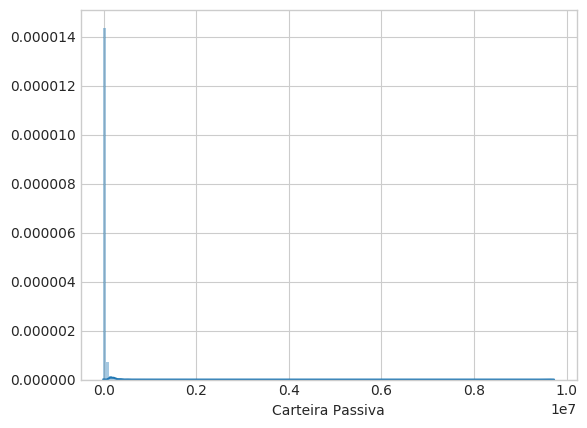

In [0]:
display(sns.distplot(clients["Carteira Passiva"], kde=True, bins=150))

#### 14.2 Carteira Activas

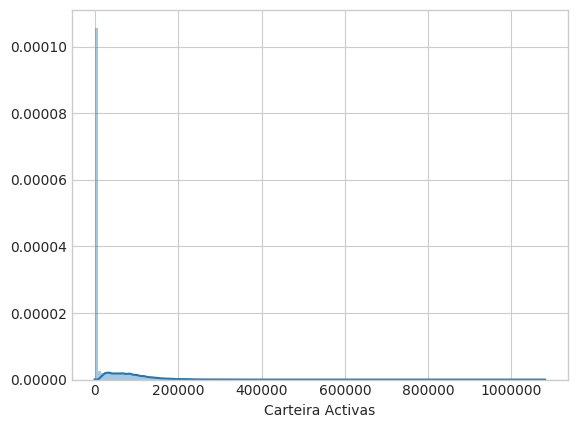

In [0]:
display(sns.distplot(clients["Carteira Activas"], kde=True, bins=150))

#### 14.3 Saldo Seguros

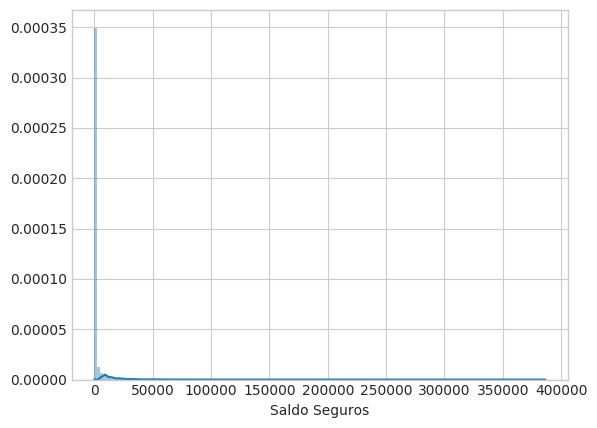

In [0]:
display(sns.distplot(clients["Saldo Seguros"], kde=True, bins=150))

#### 14.4 m_sldo_vm

In [0]:
clients["m_sldo_vm"].value_counts()

Out[48]: 0.00 44160
25.00 58
20360.00 37
20522.00 31
20232.00 30
10061.00 29
10261.00 28
10180.00 27
50.00 26
20502.00 21
2048.97 19
21014.00 18
20520.00 17
10116.00 16
1156.40 16
10260.00 15
1383.72 14
2714.22 14
3022.20 12
15270.00 12
250.00 11
15174.00 11
10251.00 11
15391.50 10
125.00 10
5130.50 9
2075.58 9
7610.50 9
377.60 8
15390.00 8
 ... 
1103.52 1
5453.48 1
9882.71 1
22517.85 1
8017.00 1
14351.40 1
259448.54 1
134.34 1
3773.23 1
7719.36 1
1996.38 1
541.54 1
20859.21 1
21342.52 1
60030.50 1
42563.21 1
11259.50 1
31871.43 1
3751.75 1
2122.03 1
22552.20 1
13363.40 1
24603.30 1
746.00 1
11.25 1
9968.92 1
5259.81 1
1491.12 1
5832.63 1
6909.75 1
Name: m_sldo_vm, Length: 4806, dtype: int64

#### 14.5 Garantia Bancaria

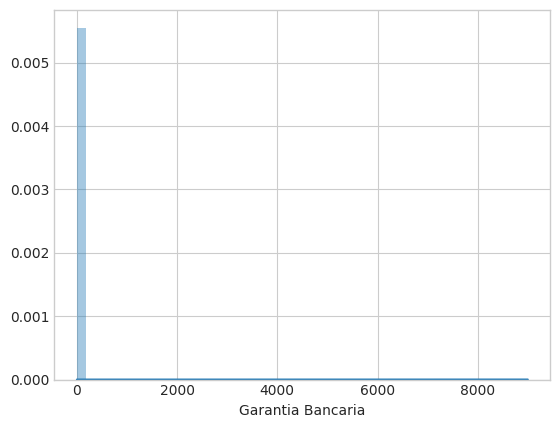

In [0]:
display(sns.distplot(clients["Garantia Bancaria"], kde=True))

#### 14.6 Credito Imobiliario

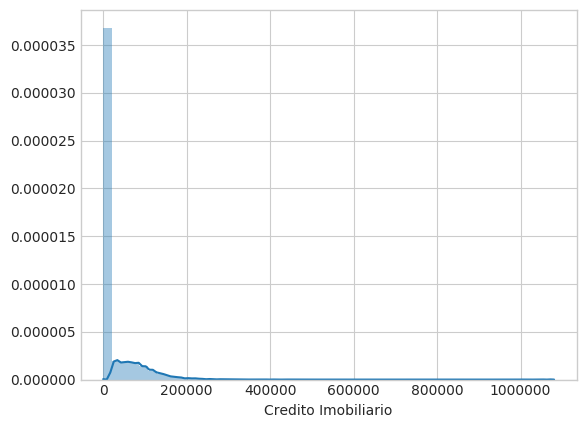

In [0]:
display(sns.distplot(clients["Credito Imobiliario"], kde=True))

#### 14.7 Credito Pessoal

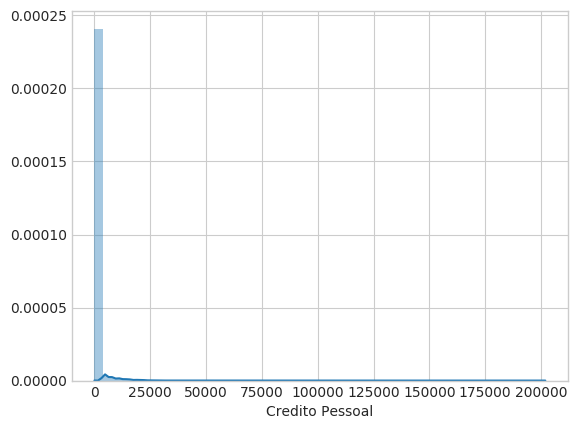

In [0]:
display(sns.distplot(clients["Credito Pessoal"], kde=True))

#### 14.7 Media de Salario a 6 meses

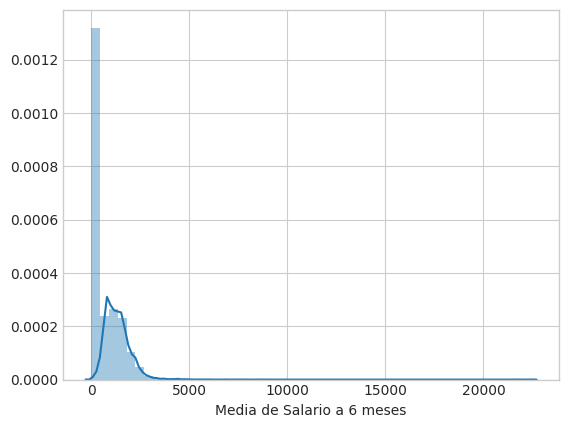

In [0]:
display(sns.distplot(clients["Media de Salario a 6 meses"], kde=True))

In [0]:
#We decided many aproaches, but like we see above, they are extremly denormalized and skewed positively which makes sense.
#we decided to make a binary variable , 0 if below 0 and 1 if above but using the mean as a 

clients["Volume Negocios"] = [1 if x >= clients["Volume Negocios"].mean() else 0 for x in clients['Volume Negocios']]
clients['Carteira Passiva'] = [1 if x >= clients['Carteira Passiva'].mean() else 0 for x in clients['Carteira Passiva']]
clients['Carteira Activas'] = [1 if x >= clients['Carteira Activas'].mean() else 0 for x in clients['Carteira Activas']]
clients['Saldo Seguros'] = [1 if x > 0 else 0 for x in clients['Saldo Seguros']]
clients['m_sldo_vm'] = [1 if x > 0 else 0 for x in clients['m_sldo_vm']]

clients['Garantia Bancaria'] = [1 if x >= clients['Garantia Bancaria'].mean() else 0 for x in clients['Garantia Bancaria']]
clients['Credito Imobiliario'] = [1 if x >= clients['Credito Imobiliario'].mean() else 0 for x in clients['Credito Imobiliario']]
clients['Credito Pessoal'] = [1 if x >= clients['Credito Pessoal'].mean() else 0 for x in clients['Credito Pessoal']]
clients['Media de Salario a 6 meses'] = [1 if x >= clients['Media de Salario a 6 meses'].mean() else 0 for x in clients['Media de Salario a 6 meses']]
        


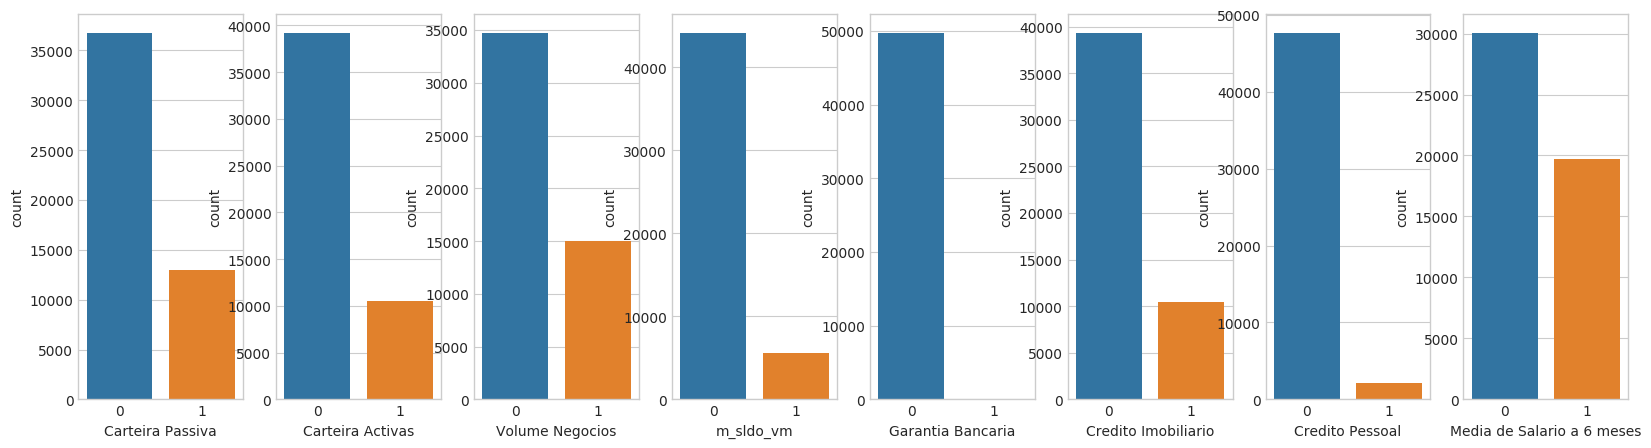

In [0]:
fig, ax = plt.subplots(nrows = 1, ncols = 8, figsize = (20, 5))
sns.countplot(x="Carteira Passiva",data= clients, ax=ax[0])
sns.countplot(x="Carteira Activas",data= clients, ax=ax[1])
sns.countplot(x="Volume Negocios",data= clients, ax=ax[2])
sns.countplot(x="m_sldo_vm",data= clients, ax=ax[3])

sns.countplot(x="Garantia Bancaria",data= clients, ax=ax[4])
sns.countplot(x="Credito Imobiliario",data= clients, ax=ax[5])
sns.countplot(x="Credito Pessoal",data= clients, ax=ax[6])
sns.countplot(x="Media de Salario a 6 meses",data= clients, ax=ax[7])
display(fig)

#### 15. Recebe Salario

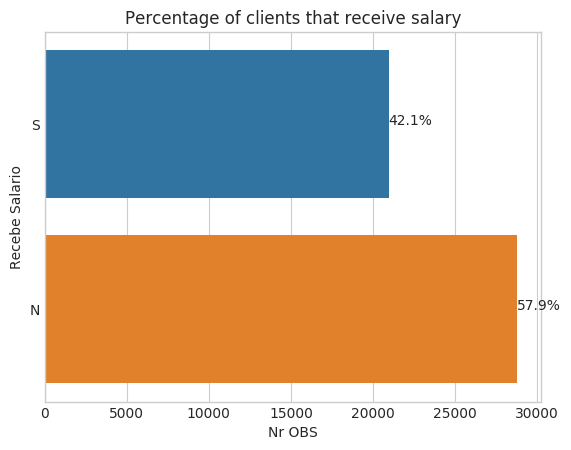

In [0]:
distribuiçao_genero = sns.countplot(y = 'Recebe Salario', data = clients)
plt.title('Percentage of clients that receive salary')
plt.xlabel('Nr OBS')

total = len(clients['Recebe Salario'])
for p in distribuiçao_genero.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    distribuiçao_genero.annotate(percentage, (x, y))
display(plt.show())

# Aproximadamente 60% dos clientes no dataset não recebem salário.

In [0]:
clients['Recebe Salario'] = [1 if x == "S" else 0 for x in clients['Recebe Salario']]

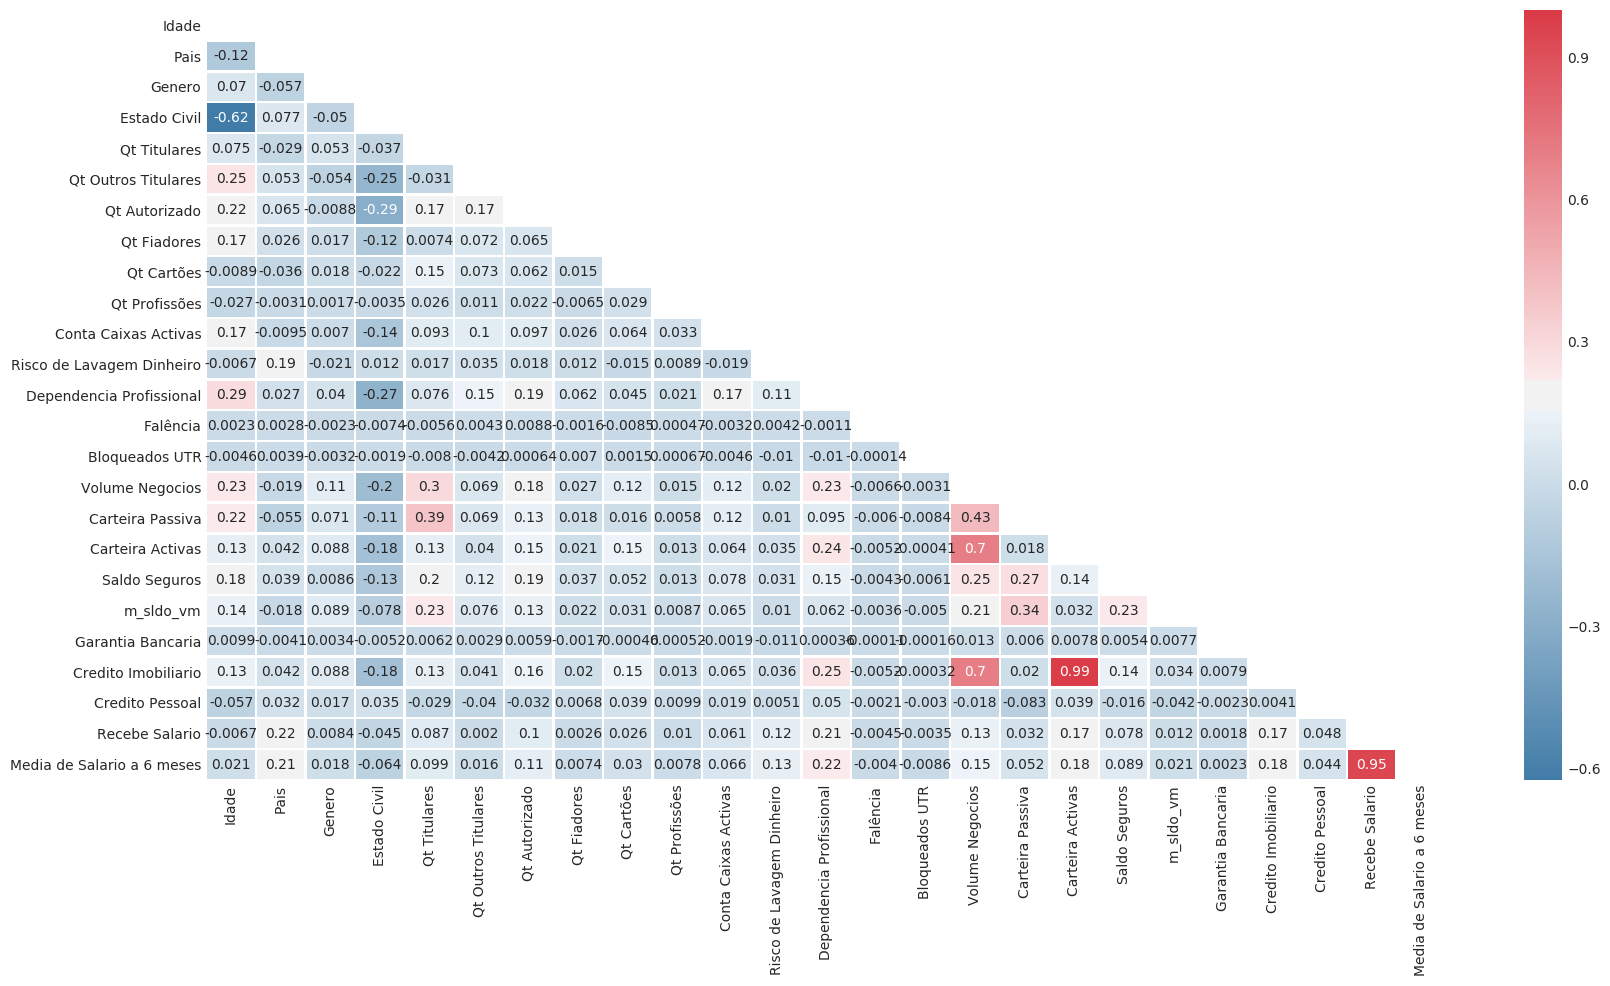

In [0]:
#There are clearly very correlated which need to be either removed or not used in the same clusters 


matrix = np.triu(clients.corr())
clients.corr()
plt.figure(figsize=(20,10))
sns.heatmap(clients.corr(),annot=True, linewidth=1, cmap = sns.diverging_palette(240,10,as_cmap=True), mask=matrix)
display(plt.show())

#### 16. Data Selection

In [0]:
clients = clients.drop(
    columns=[
        "Bloqueados UTR",
        "Falência",
        "Qt Fiadores",
        "Qt Profissões",
        "Homebanking",
    ]
)

#### Analysis

In [0]:
#  ------- Problems in cluster version made us not be able to display plots --------- # 


#fig, axes = plt.subplots(figsize=(10, 4))
#distribuiçao_idade = sns.histplot(x = 'Idade', data = clients, hue = 'Genero', kde = True, binwidth = 1)
#display(plt.show())

# Os clientes mais jovens (até aos 35) são maioritariamente mulheres, mas a partir dos 35, a maioria dos clientes é do género masculino. Contudo não existem discrepâncias significativas.

In [0]:
#  ------- Problems in cluster version made us not be able to display plots --------- # 


#"Recebe_salario_y = 'Recebe salário'
#Recebe_salario_n = 'Não recebe salário'
#fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
#mulher = clients[clients['Genero']==0]
#homem = clients[clients['Genero']==1]

#ax = sns.histplot(mulher[mulher['Recebe Salario']==1].Idade, bins=30, color = 'green', label = Recebe_salario_y, ax = axes[0], kde =False)
#ax = sns.histplot(mulher[mulher['Recebe Salario']==0].Idade, bins=30, color = 'red', label = Recebe_salario_n, ax = axes[0], kde =False)
#ax.set_title('Mulher')
#ax.legend()

#ax = sns.histplot(homem[homem['Recebe Salario']==1].Idade, bins=30, color = 'green', label = Recebe_salario_y, ax = axes[1], kde = False)
#ax = sns.histplot(homem[homem['Recebe Salario']==0].Idade, bins=30, color = 'red', label = Recebe_salario_n, ax = axes[1], kde = False)
#_ = ax.set_title('Homem')
#ax.legend()

#display(plt.show())

# Podemos ver pelos gráficos abaixo que a maioria dos clientes não recebe salário. A partir dos 65 verifica-se uma diminuição significativa no número de clientes que recebem salário. Isto deve-se à entrada no período de reforma.

## E. Feature Creation

 Run the data mining tools

#### 1. Feature Building

#### 1.1 Antiguidade Cliente

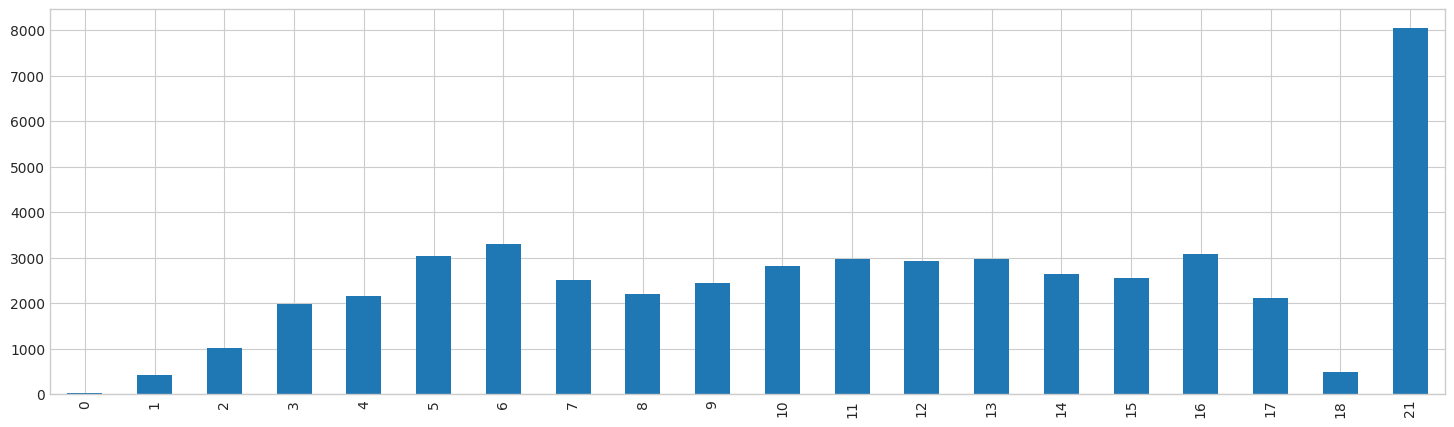

In [0]:
#Creating a variable to display the time that the cliets is present in homebanking
clients["Antiguidade Cliente"] = pd.to_datetime(clients["Data Adesão"])
clients["Antiguidade Cliente"] = 2021 - clients["Antiguidade Cliente"].dt.year

clients = clients.drop(
    columns=[
        "Data Adesão",
    ]
)

display(clients['Antiguidade Cliente'].value_counts().sort_index().plot.bar(figsize=(18,5)))

#### 1.2 Taxa Poupança

In [0]:
# Rate of saving. For this variable, we use the average salary of the last 6 months and divide it by Carteira Passiva (how much does he have in his savings account) to get an insight of client's saving capacity
clients['Taxa Poupança'] = clients['Media de Salario a 6 meses']/clients['Carteira Passiva']

#### 1.3 Credit Effort

In [0]:
# Client's credit effort. For this variable, we divide the average salary of the last 6 months by the sum of his credits (Credito Imobiliario+Credito Pessoal) to get a measure of client's credit effort.

clients['Credit Effort'] = clients['Media de Salario a 6 meses']/(clients['Credito Imobiliario'] + clients['Credito Pessoal'])

In [0]:
clients['Credit Effort'].replace(np.inf, 0, inplace=True)
clients['Credit Effort'].replace(np.nan, 0, inplace=True)
#clients['Credit Effort'].astype(int)

clients['Taxa Poupança'].replace(np.inf, 0, inplace=True)
clients['Taxa Poupança'].replace(np.nan, 0, inplace=True)
#clients['Taxa Poupança'].astype(int)

## F. Modeling

 Standardize and Model

In [0]:
clientes_withclusters = clients[["Cliente"]]

#### 1. Dummy Variables Creation

In [0]:
# Not used 

#Tipo Caixa
#clients = pd.get_dummies(clients, columns = ['Tipo Caixa'], drop_first = True, dtype = int)

# Risco de Lavage Dinheiro
#clients = pd.get_dummies(clients, columns = ['Risco de Lavagem Dinheiro'], drop_first = True, dtype = int)

# Descontrução para ter o top 10 das profissões mais usadas
#clients['profissao_engenheiro'] = [1 if x == 'ENGENHEIRO ELECTROTECNICO' or x == 'ENGENHEIRO MECANICO' or x == 'ENGENHEIRO AGRONOMO' or x == 'ENGENHEIRO OBRAS ENG.CIVIL' or x == 'ENGENHEIRO AMBIENTE' or x == 'ENGENHEIRO QUIMICO' or x == 'TECNICO ENGENHARIA CIVIL' or x == 'ENGENHEIRO ELECTRONICO' or x == 'ENG. CONSTRUCAO EDIFICIOS' or x == 'ENGENHEIRO DE TELECOMUNICACOES' or x == 'ENGENHEIRO INDUSTRIAL PROD.' or x == 'ENGENHEIRO METALURGICO' or x == 'ENGENHEIRO DE MINAS' or x == 'ENGENHEIRO FLORESTAL' or x == 'OUT.ENG.REL.C/MINAS METALURGIA' else 0 for x in clients['Profissão']]
#clients['profissao_professor'] = [1 if x == 'PROF.ENS.BASICO(2º 3º)SECUND.' or x == 'PROF.ENSINO BASICO (1º CICLO)' or x == 'PROF.ENS.UNIVERSITARIO SUPER.' or x == 'PROFESSOR ENSINO ESPECIAL' or x == 'PROF.ENS.TECNOLG.ART.PROFIS.' or x == 'OUTROS PROFESSORES MUSICA' or x == 'OUTROS PROFESSORES LINGUAS' or x == 'OUTROS PROFESSORES DE ARTE' else 0 for x in clients['Profissão']]
#clients['profissao_desempregado'] = [1 if x == 'SEM PROFISSAO' else 0 for x in clients['Profissão']]
#clients['profissao_estudante'] = [1 if x == 'ESTUDANTE' else 0 for x in clients['Profissão']]
#clients['profissao_funcionarioPublico'] = [1 if x == 'FUNCIONARIO PUBLICO' else 0 for x in clients['Profissão']]
#clients['profissao_empregadoEscritorioGeral'] = [1 if x == 'EMPREGADO ESCRITORIO GERAL' else 0 for x in clients['Profissão']]
#clients['profissao_outrosAgentesPolicia'] = [1 if x == 'OUTROS AGENTES POLICIA' else 0 for x in clients['Profissão']]
#clients['profissao_enfermeiroCuidadosGerais'] = [1 if x == 'ENFERMEIRO CUIDADOS GERAIS' else 0 for x in clients['Profissão']]
#clients['profissao_arquiteto'] = [1 if x == 'ARQUITETO  EDIFICIOS' else 0 for x in clients['Profissão']]



#### 2. Feature selection | Clustering

#### 2.1 Cluster 1 - Demographic

In [0]:
#We could attepmt on several different types of cluster analysis like having geographic using localidade and creating new feature , for instance, if the area (m2) of that region compared to lisbon or the ammount of habitants 

In [0]:
#Features to use in cluster 1
cols_to_Use = [

'Cliente', 
'Idade', 
'Pais', 
'Genero', 
#'Tipo Caixa', 
'Estado Civil',
#'Localidade', 
  
#'Qt Titulares', 
#'Qt Outros Titulares', 
#'Qt Autorizado',
#'Qt Cartões', 
  
#'Conta Caixas Activas', 
#'Risco de Lavagem Dinheiro',
  
#'Profissão', 
#'Tipo de Profissão', 
#'Dependencia Profissional',
  
#'profissao_engenheiro',
#'profissao_desempregado',
#"profissao_estudante",
#"profissao_professor",
#"profissao_funcionarioPublico",
#"profissao_empregadoEscritorioGeral",
#"profissao_outrosAgentesPolicia",
#"profissao_enfermeiroCuidadosGerais",
#"profissao_arquiteto",
  
#'Carteira Passiva', 
#'Carteira Activas', 
#'Saldo Seguros', 
#'m_sldo_vm',
#'Garantia Bancaria', 
#'Credito Imobiliario', 
#'Credito Pessoal',
#'Recebe Salario', 
#'Media de Salario a 6 meses',

"Antiguidade Cliente",
#"Credit Effort",
#"Taxa Poupança",


]
# ALTERAR nome df para clientes_modeling cluster 1
clientes_modeling_cluster1 = clients[cols_to_Use]

In [0]:
#Convert datatypes from pandas to pyspark

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = SparkSession.builder.getOrCreate()

from pyspark.sql.types import *

# Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlContext.createDataFrame(pandas_df, p_schema)

In [0]:
#Turn Panda's dataframe to SPARK dataframe

clientes_modeling_cluster1 = pandas_to_spark(clientes_modeling_cluster1)
clientes_withclusters = pandas_to_spark(clientes_withclusters)

In [0]:
#Creating Vectors and feature hashing

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assemble = VectorAssembler(
    inputCols=["Idade", "Genero","Estado Civil","Antiguidade Cliente","Pais"],
    outputCol="features")

assembled_data=assemble.transform(clientes_modeling_cluster1).select('Cliente', 'features')
assembled_data.show(5)

+--------------------+--------------------+
 Cliente| features|
+--------------------+--------------------+
8e5cefc583234aa5a...|[34.0,1.0,1.0,5.0...|
9df57aec8601475ca...|[39.0,0.0,0.0,13....|
a8df30d3249f4a8ea...|[41.0,0.0,0.0,21....|
6cf073affd174287a...|[43.0,0.0,0.0,21....|
2863fcc0a33446468...|[26.0,1.0,1.0,8.0...|
+--------------------+--------------------+
only showing top 5 rows

In [0]:
#Normalization of the vector

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data).select('Cliente', 'standardized')
data_scale_output.show(2)

+--------------------+--------------------+
 Cliente| standardized|
+--------------------+--------------------+
8e5cefc583234aa5a...|[2.58335571968532...|
9df57aec8601475ca...|[2.96326097258022...|
+--------------------+--------------------+
only showing top 2 rows

In [0]:
from pyspark.ml.clustering import KMeans

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("standardized")
    model = kmeans.fit(data_scale_output.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(data_scale_output) 

In [0]:
#Finding a good K 

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.3560504018278824
Silhouette Score: 0.41203660513834767
Silhouette Score: 0.5217588096478472
Silhouette Score: 0.47163501135919406
Silhouette Score: 0.5601010552001007
Silhouette Score: 0.5684230792675947
Silhouette Score: 0.5891037694018038
Silhouette Score: 0.5860942216195058

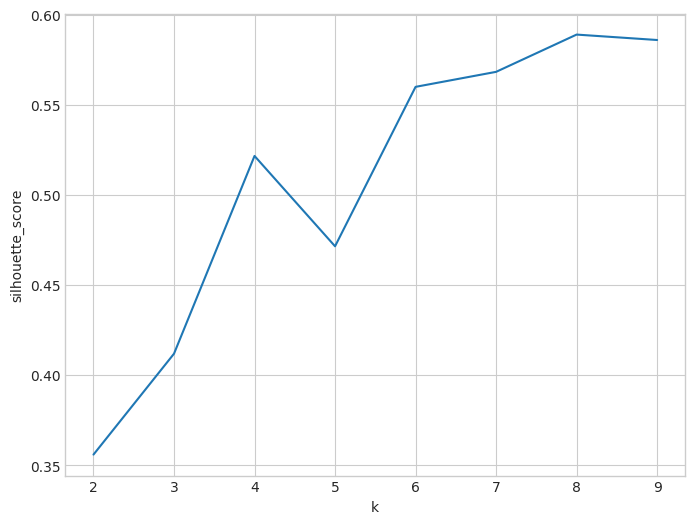

In [0]:
#Visualizing the silhouette scores in a plot
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("silhouette_score")
display(fig)


In [0]:
#Choosing optimal K

k = 4
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("standardized")
model = kmeans.fit(data_scale_output)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[3.22778656 1.08110325 2.01787093 2.656363 3.60719729]
[3.82810114 0. 0.00638762 2.29467517 3.63288121]
[3.99115953 2.00068343 0.00697742 2.49584916 3.43427497]
[2.23674651 0.92388539 1.98600981 1.17379716 3.74770961]

In [0]:
#Mergin the clusters 1 with the clients hash

transformed = model.transform(data_scale_output).select('Cliente', 'prediction').withColumnRenamed("prediction", "Cluster1")
df_pred_cluster1 = transformed.join(clientes_withclusters, 'Cliente')
display(df_pred_cluster1)

Cliente,Cluster1
002afea497f94289ab069acbe8d9cf99,3
06bda74547fb4bbfb9fbdb2f5e0a015a,0
072950b96d834957ae64035bc9f09290,3
074212fb88214bfd8d6a9b858a9b68c0,1
0986be4cea2c41a09139c51fecb2a93b,2
0b0b4dcc987b4dbd99dbff197dc29216,1
0c3e30eba6604fd2ada9fe49c2f6e0e0,3
0c57cb72945f4e9a8b7304025b1f54cc,0
0cb009d12a634b919c03a8718f259900,3
0cfd4d59ac134dbd936d1aade3561198,2


In [0]:
#Cluster distribution
Graph = df_pred_cluster1.select("Cluster1").toPandas()
display(Graph)

Cluster1
3
0
3
1
2
1
3
0
3
2


#### 1.2 Cluster 2 - Finantial Behavioural

In [0]:

#Features to use IN CLUSTER 2
cols_to_Use = [

'Cliente', 
  
'Qt Titulares', 
'Qt Cartões', 
  
'Conta Caixas Activas', # Pacote de serviço 
#'Risco de Lavagem Dinheiro',

#"Volume Negocios",  
'Carteira Passiva', 
'Carteira Activas', 
#'Credito Imobiliario', 
#'Credito Pessoal',
#'Recebe Salario', #Cant use this since its highly correlated with "media de salario a 6 meses"
'Media de Salario a 6 meses',

#"Antiguidade Cliente",
#"Credit Effort",
#"Taxa Poupança",

]

clientes_modeling_cluster2 = clients[cols_to_Use]

In [0]:
clientes_modeling_cluster2 = pandas_to_spark(clientes_modeling_cluster2)

In [0]:
#Creating Vectors and feature hashing

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assemble = VectorAssembler(
    inputCols=['Qt Titulares', 'Qt Cartões','Conta Caixas Activas',"Carteira Passiva","Carteira Activas","Media de Salario a 6 meses"],
    outputCol="features")

assembled_data=assemble.transform(clientes_modeling_cluster2).select('Cliente', 'features')
assembled_data.show(5)

+--------------------+--------------------+
 Cliente| features|
+--------------------+--------------------+
8e5cefc583234aa5a...|[2.0,3.0,1.0,1.0,...|
9df57aec8601475ca...|[5.0,3.0,1.0,0.0,...|
a8df30d3249f4a8ea...|[1.0,3.0,1.0,0.0,...|
6cf073affd174287a...|[3.0,4.0,1.0,0.0,...|
2863fcc0a33446468...|[3.0,3.0,1.0,0.0,...|
+--------------------+--------------------+
only showing top 5 rows

In [0]:
#Normalization of the vector

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data).select('Cliente', 'standardized')
data_scale_output.show(2)

+--------------------+--------------------+
 Cliente| standardized|
+--------------------+--------------------+
8e5cefc583234aa5a...|[1.77460405675657...|
9df57aec8601475ca...|[4.43651014189144...|
+--------------------+--------------------+
only showing top 2 rows

In [0]:
#choosing k means

from pyspark.ml.clustering import KMeans

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("standardized")
    model = kmeans.fit(data_scale_output.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(data_scale_output) # requires Spark 2.0 or later

In [0]:
#Finding a good K 

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.39494229539730036
Silhouette Score: 0.38716501862864067
Silhouette Score: 0.41717175656078903
Silhouette Score: 0.352333798124683
Silhouette Score: 0.3714494359471744
Silhouette Score: 0.41140582828576955
Silhouette Score: 0.4334859545564374
Silhouette Score: 0.4429942528596946

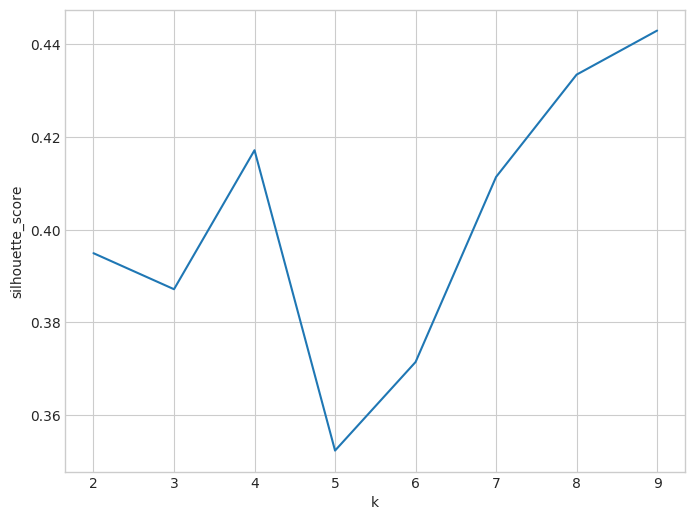

In [0]:
#Visualizing the silhouette scores in a plot
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("silhouette_score")
display(fig)

In [0]:
#Finding a good K 

k = 4
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("standardized")
model = kmeans.fit(data_scale_output)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.44793697 1.68138425 0. 0.15384539 0.07765519 0.51038329]
[2.08427351 2.19200163 1.87039256 0.64634468 2.44653732 1.20053346]
[1.53099035 1.82855223 2.28228567 0. 0. 0.7471027 ]
[2.45702788e+00 1.81180766e+00 2.02656671e+00 2.27759553e+00
 1.56287015e-03 8.34281389e-01]

In [0]:
transformed = model.transform(data_scale_output).select('Cliente', 'prediction').withColumnRenamed("prediction", "Cluster2")
df_pred_cluster2 = transformed.join(clientes_withclusters, 'Cliente')
display(df_pred_cluster2)

Cliente,Cluster2
002afea497f94289ab069acbe8d9cf99,0
06bda74547fb4bbfb9fbdb2f5e0a015a,1
072950b96d834957ae64035bc9f09290,0
074212fb88214bfd8d6a9b858a9b68c0,2
0986be4cea2c41a09139c51fecb2a93b,3
0b0b4dcc987b4dbd99dbff197dc29216,0
0c3e30eba6604fd2ada9fe49c2f6e0e0,3
0c57cb72945f4e9a8b7304025b1f54cc,2
0cb009d12a634b919c03a8718f259900,0
0cfd4d59ac134dbd936d1aade3561198,0


In [0]:
#Meter Bonito
Graph = df_pred_cluster2.select("Cluster2").toPandas()
display(Graph)

Cluster2
0
1
0
2
3
0
3
2
0
0


#### Analise e Exportação

#### Dataset + Clusters

In [0]:
#Display of clients and their clusters

Clusters1_2 = df_pred_cluster1.join(df_pred_cluster2, 'Cliente')
display(Clusters1_2)

Cliente,Cluster1,Cluster2
002afea497f94289ab069acbe8d9cf99,3,0
06bda74547fb4bbfb9fbdb2f5e0a015a,0,1
072950b96d834957ae64035bc9f09290,3,0
074212fb88214bfd8d6a9b858a9b68c0,1,2
0986be4cea2c41a09139c51fecb2a93b,2,3
0b0b4dcc987b4dbd99dbff197dc29216,1,0
0c3e30eba6604fd2ada9fe49c2f6e0e0,3,3
0c57cb72945f4e9a8b7304025b1f54cc,0,2
0cb009d12a634b919c03a8718f259900,3,0
0cfd4d59ac134dbd936d1aade3561198,2,0


In [0]:
#Joining data to main dataset

Cluster1 = Clusters1_2[["Cliente" , "Cluster1" ]]
Cluster2 = Clusters1_2[["Cliente" , "Cluster2" ]]

clientes_modeling_cluster1_with_cluster = clientes_modeling_cluster1.join(Cluster1, 'Cliente')
clientes_modeling_cluster2_with_cluster = clientes_modeling_cluster2.join(Cluster2, 'Cliente')

In [0]:
clients_Export_Clusters = clients_Export.join(Clusters1_2, 'Cliente')
display(clients_Export_Clusters)

Cliente,Idade,Pais,Genero,Tipo Caixa,Estado Civil,Localidade,Qt Titulares,Qt Outros Titulares,Qt Autorizado,Qt Fiadores,Qt Cartões,Qt Profissões,Homebanking,Data Adesão,Conta Caixas Activas,Risco de Lavagem Dinheiro,Profissão,Tipo de Profissão,Dependencia Profissional,Falência,Bloqueados UTR,Volume Negocios,Carteira Passiva,Carteira Activas,Saldo Seguros,m_sldo_vm,Garantia Bancaria,Credito Imobiliario,Credito Pessoal,Recebe Salario,Media de Salario a 6 meses,Cluster1,Cluster2
002afea497f94289ab069acbe8d9cf99,25,PT,F,CAIXA DIRECTA IU,SOLTEIRO,FERNAO FERRO,3,0,0,0,2,1,S,2015-08-31,0,B-BAIXO,ESTUDANTE,SIT DSCNH,DEP DSCNH,0,0,9361.68,9361.68,0.0,0.0,0.0,0.0,0.0,0.0,S,761.43,3,0
06bda74547fb4bbfb9fbdb2f5e0a015a,44,PT,F,CAIXA MAIS,SOLTEIRO,SAMOUCO,1,0,0,0,3,1,S,2010-02-05,1,M-MEDIO,ESTUDANTE,SIT DSCNH,DEP DSCNH,0,0,120259.08,-446.19,120705.27,0.0,0.0,0.0,120705.27,0.0,N,0.0,0,1
072950b96d834957ae64035bc9f09290,24,PT,M,CAIXA DIRECTA IU,SOLTEIRO,ABRANTES,2,0,0,0,4,1,S,2019-04-26,0,B-BAIXO,ENGENHEIRO MECANICO,TECNICO,OUTREM,0,0,8049.51,8049.51,0.0,0.0,969.49,0.0,0.0,0.0,N,0.0,3,0
074212fb88214bfd8d6a9b858a9b68c0,57,PT,F,CAIXA MAIS,CASADO,SASSOEIROS,0,2,4,0,2,1,S,2000-01-01,1,M-MEDIO,ESTUDANTE,SIT DSCNH,DEP DSCNH,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,0.0,1,2
0986be4cea2c41a09139c51fecb2a93b,70,PT,M,CAIXA MAIS,CASADO REG COMUNHAO GERAL BENS,VALPACOS,3,1,0,0,3,1,S,2013-11-20,2,B-BAIXO,FUNCIONARIO PUBLICO,REFORMADO,OUTREM,0,0,35025.71,35025.71,0.0,7012.08,0.0,0.0,0.0,0.0,N,0.0,2,3
0b0b4dcc987b4dbd99dbff197dc29216,63,PT,F,CAIXA MAIS,CASADO REG COMUNHAO ADQUIRIDOS,OLIVEIRA DO DOURO,2,0,0,0,1,1,S,2007-11-16,0,B-BAIXO,DATILOGRAFO OPER.PROC.TEXTO,REFORMADO,OUTROS,0,0,1643.96,1643.96,0.0,0.0,0.0,0.0,0.0,0.0,N,0.0,1,0
0c3e30eba6604fd2ada9fe49c2f6e0e0,29,PT,F,CAIXA MAIS,SOLTEIRO,AMADORA,2,0,0,0,2,1,S,2015-02-23,1,B-BAIXO,ESTUDANTE,SIT DSCNH,DEP DSCNH,0,0,23079.38,22680.78,398.6,0.0,0.0,0.0,0.0,398.6,N,0.0,3,3
0c57cb72945f4e9a8b7304025b1f54cc,37,PT,F,CAIXA MAIS,SOLTEIRO,CHARNECA DE CAPARICA,1,0,0,0,2,1,S,2000-01-01,1,B-BAIXO,ASSISTENTE DE MEDICOS,OPERARIO ESPECIALIZADO,OUTREM,0,0,-499.35,-499.35,0.0,0.0,0.0,0.0,0.0,0.0,S,755.15,0,2
0cb009d12a634b919c03a8718f259900,25,PT,F,CAIXA MAIS,SOLTEIRO,TAPADA DAS MERCES,2,0,0,0,1,1,S,2016-06-30,0,M-MEDIO,VENDEDOR LOJA (ESTABELEC.),COMERCIANTE,OUTREM,0,0,8565.7,357.42,8208.28,0.0,0.0,0.0,0.0,8208.28,S,665.61,3,0
0cfd4d59ac134dbd936d1aade3561198,48,PT,M,CAIXA MAIS,CASADO,AMADORA,2,0,0,0,2,1,S,2004-03-30,0,B-BAIXO,OPERADOR CENTRAL TELEFONICA,ADMINISTRATIVO,OUTREM,0,0,95274.98,95274.98,0.0,0.0,94822.0,0.0,0.0,0.0,N,0.0,2,0


#### Cluster 1
Describing each from cluster 1

In [0]:
display(clientes_modeling_cluster1_with_cluster)

In [0]:
#Cluster 1

d1c1 = clientes_modeling_cluster1_with_cluster[clientes_modeling_cluster1_with_cluster["Cluster1"] == 0 ].toPandas()
summary=d1c1.describe()
summary=summary.transpose()
summary.head(len(summary))

#Analise
#IDADE - media de 42 anos
#PAIS - apenas portugal
#GENERO - misto ( 1: M , 0:F)
#ESTADO CIVIL - solteiros (1:S , 0:C)
#ANIGUIDADE CLIENTE – 15 anos


,count,mean,std,min,25%,50%,75%,max
Idade,10900.0,42.481468,8.013987,28.0,37.0,41.0,46.0,80.0
Pais,10900.0,0.925505,0.262587,0.0,1.0,1.0,1.0,1.0
Genero,10900.0,0.540367,0.498391,0.0,0.0,1.0,1.0,1.0
Estado Civil,10900.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Antiguidade Cliente,10900.0,15.349908,3.641009,2.0,13.0,15.0,17.0,21.0
Cluster1,10900.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [0]:
#Cluster 2

d1c1 = clientes_modeling_cluster1_with_cluster[clientes_modeling_cluster1_with_cluster["Cluster1"] == 1 ].toPandas()
summary=d1c1.describe()
summary=summary.transpose()
summary.head(len(summary))

#Analise
#IDADE - media de 50 anos
#PAIS - portugal
#GENERO - Feminino ( 1: M , 0:F)
#ESTADO CIVIL - Casado (1:S , 0:C) 
#ANIGUIDADE CLIENTE - 13 anos media


,count,mean,std,min,25%,50%,75%,max
Idade,9793.0,50.382314,10.923048,26.0,42.0,49.0,58.0,80.0
Pais,9793.0,0.932094,0.251597,0.0,1.0,1.0,1.0,1.0
Genero,9793.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Estado Civil,9793.0,0.003166,0.056177,0.0,0.0,0.0,0.0,1.0
Antiguidade Cliente,9793.0,13.259880,5.653185,0.0,9.0,14.0,17.0,21.0
Cluster1,9793.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [0]:
#Cluster 3

d1c2 = clientes_modeling_cluster1_with_cluster[clientes_modeling_cluster1_with_cluster["Cluster1"] == 2 ].toPandas()
summary=d1c2.describe()
summary=summary.transpose()
summary.head(len(summary))

#Analise
#IDADE - media de 52 anos
#PAIS - portuga
#GENERO - Masculino ( 1: M , 0:F)
#ESTADO CIVIL - Casados 
#ANIGUIDADE CLIENTE - 14 anos media


,count,mean,std,min,25%,50%,75%,max
Idade,11568.0,52.528354,10.878490,24.0,44.0,51.0,60.0,80.0
Pais,11568.0,0.881138,0.323640,0.0,1.0,1.0,1.0,1.0
Genero,11568.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Estado Civil,11568.0,0.003458,0.058704,0.0,0.0,0.0,0.0,1.0
Antiguidade Cliente,11568.0,14.422372,5.723993,0.0,10.0,15.0,21.0,21.0
Cluster1,11568.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0


In [0]:
#Cluster 4

d1c3 = clientes_modeling_cluster1_with_cluster[clientes_modeling_cluster1_with_cluster["Cluster1"] == 3 ].toPandas()
summary=d1c3.describe()
summary=summary.transpose()
summary.head(len(summary))

#Analise
#IDADE - media de 32 anos
#PAIS - em portugal
#GENERO - HOMEM
#ESTADO CIVIL - solteiro 
#ANIGUIDADE CLIENTE - 9 anos media


,count,mean,std,min,25%,50%,75%,max
Idade,17480.0,29.438215,6.096471,18.0,26.0,28.0,32.0,65.0
Pais,17480.0,0.961556,0.192271,0.0,1.0,1.0,1.0,1.0
Genero,17480.0,0.461785,0.498552,0.0,0.0,0.0,1.0,1.0
Estado Civil,17480.0,0.984211,0.124664,0.0,1.0,1.0,1.0,1.0
Antiguidade Cliente,17480.0,6.782838,2.900861,0.0,5.0,6.0,9.0,14.0
Cluster1,17480.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0


#### Cluster 2
Describing each from cluster 2

In [0]:
clientes_modeling_cluster2_with_cluster_Pandas = clientes_modeling_cluster2_with_cluster.toPandas()
summary=clientes_modeling_cluster2_with_cluster_Pandas.describe()
summary=summary.transpose()
summary.head(len(summary))


,count,mean,std,min,25%,50%,75%,max
Qt Titulares,49741.0,2.031845,1.127012,0.0,1.0,2.0,3.0,5.0
Qt Cartões,49741.0,2.557066,1.367093,0.0,2.0,2.0,3.0,8.0
Conta Caixas Activas,49741.0,0.740878,0.438157,0.0,0.0,1.0,1.0,1.0
Carteira Passiva,49741.0,0.260771,0.439060,0.0,0.0,0.0,1.0,1.0
Carteira Activas,49741.0,0.211676,0.408501,0.0,0.0,0.0,0.0,1.0
Media de Salario a 6 meses,49741.0,0.395649,0.488995,0.0,0.0,0.0,1.0,1.0
Cluster2,49741.0,1.581834,1.011436,0.0,1.0,2.0,2.0,3.0


In [0]:
#Cluster 1

d1c1 = clientes_modeling_cluster2_with_cluster[clientes_modeling_cluster2_with_cluster["Cluster2"] == 0 ].toPandas()
summary=d1c1.describe()
summary=summary.transpose()
summary.head(len(summary))

#Analise
#Qt Titulares - 1 ( muitos)
#Qt Cartões -  2 cartões media 
#Conta Caixas Activas – 0 caixa
#Carteira Passiva – 0  ( 1: acima da media , 0 : abaixo )
#Carteira Activas – 0 ( 1: acima da media , 0 : abaixo )
#Media de Salario a 6 meses – bastante abaixo da média


,count,mean,std,min,25%,50%,75%,max
Qt Titulares,9993.0,1.631842,0.864785,0.0,1.0,1.0,2.0,5.0
Qt Cartões,9993.0,2.298609,1.289273,0.0,1.0,2.0,3.0,8.0
Conta Caixas Activas,9993.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Carteira Passiva,9993.0,0.067547,0.250980,0.0,0.0,0.0,0.0,1.0
Carteira Activas,9993.0,0.031722,0.175268,0.0,0.0,0.0,0.0,1.0
Media de Salario a 6 meses,9993.0,0.249575,0.432789,0.0,0.0,0.0,0.0,1.0
Cluster2,9993.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [0]:
#Cluster 2

d1c2 = clientes_modeling_cluster2_with_cluster[clientes_modeling_cluster2_with_cluster["Cluster2"] == 1 ].toPandas()
summary=d1c2.describe()
summary=summary.transpose()
summary.head(len(summary))

#Analise
#Qt Titulares - 2 
#Qt Cartões -  3 cartões media
#Conta Caixas Activas - 1 contas caixa
#Carteira Passiva – 0 ( 1: acima da media , 0 : abaixo )
#Carteira Activas – 1 ( 1: acima da media , 0 : abaixo )
#Media de Salario a 6 meses - na média ( 1: acima da media , 0 : abaixo )


,count,mean,std,min,25%,50%,75%,max
Qt Titulares,10212.0,2.349001,1.235162,0.0,1.0,2.0,3.0,5.0
Qt Cartões,10212.0,2.996671,1.332709,0.0,2.0,3.0,4.0,8.0
Conta Caixas Activas,10212.0,0.819526,0.384601,0.0,1.0,1.0,1.0,1.0
Carteira Passiva,10212.0,0.283784,0.450855,0.0,0.0,0.0,1.0,1.0
Carteira Activas,10212.0,0.999412,0.024233,0.0,1.0,1.0,1.0,1.0
Media de Salario a 6 meses,10212.0,0.587054,0.492387,0.0,0.0,1.0,1.0,1.0
Cluster2,10212.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [0]:
#Cluster 3

d1c3 = clientes_modeling_cluster2_with_cluster[clientes_modeling_cluster2_with_cluster["Cluster2"] == 2 ].toPandas()
summary=d1c3.describe()
summary=summary.transpose()
summary.head(len(summary))

#Analise
#Qt Titulares - 2
#Qt Cartões -  3
#Conta Caixas Activas - 1
#Carteira Passiva – 0 ( 1: acima da media , 0 : abaixo )
#Carteira Activas – 0 ( 1: acima da media , 0 : abaixo )
#Media de Salario a 6 meses – abaixo da medio ( 1: acima da media , 0 : abaixo )


,count,mean,std,min,25%,50%,75%,max
Qt Titulares,20138.0,1.725444,0.936346,0.0,1.0,2.0,2.0,5.0
Qt Cartões,20138.0,2.499801,1.369626,0.0,1.0,2.0,3.0,8.0
Conta Caixas Activas,20138.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Carteira Passiva,20138.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Carteira Activas,20138.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Media de Salario a 6 meses,20138.0,0.365329,0.481534,0.0,0.0,0.0,1.0,1.0
Cluster2,20138.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0


In [0]:
#Cluster 4

d1c4 = clientes_modeling_cluster2_with_cluster[clientes_modeling_cluster2_with_cluster["Cluster2"] == 3 ].toPandas()
summary=d1c4.describe()
summary=summary.transpose()
summary.head(len(summary))

#Analise
#Qt Titulares - 3
#Qt Cartões -  2
#Conta Caixas Activas - 1
#Carteira Passiva – 1 ( 1: acima da media , 0 : abaixo )
#Carteira Activas – 0 ( 1: acima da media , 0 : abaixo )
#Media de Salario a 6 meses – ligeiramente baixo ( 1: acima da media , 0 : abaixo )

,count,mean,std,min,25%,50%,75%,max
Qt Titulares,9398.0,2.769100,1.169245,0.0,2.0,3.0,4.0,5.0
Qt Cartões,9398.0,2.476910,1.371446,0.0,1.0,2.0,3.0,8.0
Conta Caixas Activas,9398.0,0.887955,0.315439,0.0,1.0,1.0,1.0,1.0
Carteira Passiva,9398.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Carteira Activas,9398.0,0.000638,0.025261,0.0,0.0,0.0,0.0,1.0
Media de Salario a 6 meses,9398.0,0.407959,0.491482,0.0,0.0,0.0,1.0,1.0
Cluster2,9398.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
